In [3]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
analyzer = SentimentIntensityAnalyzer()

In [5]:
# analiza sentymentu vader (najpierw sam)
# podzielic tweety po firmie [done]
# aggregacja godzinowo po max, min, mean, median, std, count sentymentu
# 

In [6]:
tweets = pd.read_csv('company_tweets/apple_tweets.csv')
#tweets = tweets.sample(10_000).reset_index(drop=True)

In [7]:
tweets.head()

,tweet_id,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,company_name
0,550441509175443456,2015-01-01 01:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,apple
1,550441672312512512,2015-01-01 01:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,apple
2,550443807834402816,2015-01-01 01:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,apple
3,550443808606126081,2015-01-01 01:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,apple
4,550443809700851716,2015-01-01 01:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,apple


In [8]:
def clean_body(col):
    import re
    # usun urle
    # usun hashtagi 
    pattern_url = r'https?://[a-z.]+/[?a-z0-9./]+'
    pattern_hash = r'#[a-z0-9_]+'
    col = re.sub(pattern_url, '', col, flags=re.I)
    col = re.sub(pattern_hash, '', col, flags=re.I)

    return col

In [9]:
xd = tweets['body'][37]
clean_body(xd)

'Facebook, Apple, And Microsoft ganging up on Google - Business Insider  $FB, $AAPL, $GOOG, $MSFT '

In [10]:
tweets_clean = tweets['body'].apply(clean_body)

In [11]:
tweets_sent = tweets_clean.apply(analyzer.polarity_scores)

In [12]:
tweets_sent[:5]

0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'comp...
2    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: body, dtype: object

In [13]:
def convert_dict_keyval_to_col(dict, key):
    new_col = []
    for i in dict:
        new_col.append(i[key])
    return new_col

In [14]:
sentiment_val = pd.DataFrame()
sentiment_val['pos'] = convert_dict_keyval_to_col(tweets_sent, 'pos')
sentiment_val['neu'] = convert_dict_keyval_to_col(tweets_sent, 'neu')
sentiment_val['neg'] = convert_dict_keyval_to_col(tweets_sent, 'neg')
sentiment_val['comp'] = convert_dict_keyval_to_col(tweets_sent, 'compound')


In [15]:
sentiment_val['date'] = tweets['post_date']
sentiment_val.head()

,pos,neu,neg,comp,date
0,0.0,1.000,0.000,0.0000,2015-01-01 01:00:57
1,0.0,0.661,0.339,-0.8271,2015-01-01 01:01:36
2,0.0,1.000,0.000,0.0000,2015-01-01 01:10:05
3,0.0,1.000,0.000,0.0000,2015-01-01 01:10:05
4,0.0,1.000,0.000,0.0000,2015-01-01 01:10:05


### Aggregation

In [16]:
# round down
# problem moze sie pojawic w zaleznosci od tickow stokow
# (jaki?) 
def prepare_time(col):
    date, time = col.split(' ')
    time = f'{time[0:2]}:00:00'
    return date + ' ' + time
    

In [17]:
sentiment_val['date'] = sentiment_val['date'].apply(prepare_time)
sentiment_val.head()

,pos,neu,neg,comp,date
0,0.0,1.000,0.000,0.0000,2015-01-01 01:00:00
1,0.0,0.661,0.339,-0.8271,2015-01-01 01:00:00
2,0.0,1.000,0.000,0.0000,2015-01-01 01:00:00
3,0.0,1.000,0.000,0.0000,2015-01-01 01:00:00
4,0.0,1.000,0.000,0.0000,2015-01-01 01:00:00


In [18]:
# grupuje godzinowo
#values=['comp','neg','neu','pos']
test = pd.pivot_table(sentiment_val, index=['date'], aggfunc=['max', 'min', 'std', 'mean', 'median', 'count']).reset_index()

In [19]:
test.columns = [f'{i}_{j}' for i,j in test.columns]
test['count'] = test['count_pos']

In [20]:
test.drop(['count_neg','count_neu','count_pos', 'count_comp'], axis=1, inplace=True)
test.head()

,date_,max_comp,max_neg,max_neu,max_pos,min_comp,min_neg,min_neu,min_pos,std_comp,...,std_pos,mean_comp,mean_neg,mean_neu,mean_pos,median_comp,median_neg,median_neu,median_pos,count
0,2015-01-01 01:00:00,0.6369,0.339,1.0,0.369,-0.8271,0.0,0.631,0.0,0.272298,...,0.096070,0.062482,0.023045,0.917818,0.059136,0.0000,0.000,1.0000,0.0,22
1,2015-01-01 02:00:00,0.7456,0.223,1.0,0.413,-0.5766,0.0,0.587,0.0,0.375012,...,0.124790,0.053925,0.053167,0.866500,0.080333,0.0000,0.000,0.8825,0.0,12
2,2015-01-01 03:00:00,0.8065,0.152,1.0,0.327,-0.3612,0.0,0.673,0.0,0.317696,...,0.117028,0.113570,0.015200,0.916700,0.068100,0.0000,0.000,1.0000,0.0,10
3,2015-01-01 04:00:00,0.4019,0.184,1.0,0.184,-0.2732,0.0,0.649,0.0,0.243724,...,0.086003,-0.070700,0.080000,0.869857,0.050286,-0.0772,0.123,0.8770,0.0,7
4,2015-01-01 05:00:00,0.5023,0.111,1.0,0.136,-0.2500,0.0,0.864,0.0,0.260410,...,0.062039,0.073563,0.023875,0.942625,0.033500,0.0000,0.000,0.9600,0.0,8


<AxesSubplot:xlabel='date_', ylabel='mean_pos'>

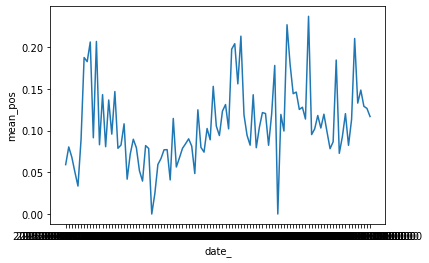

In [29]:
import seaborn as sns
dupa = test[:100]
sns.lineplot(data=dupa, x='date_', y='mean_pos')